In [21]:
import os
# os.environ['CUDA_VISIBLE_DEVICES'] = '2'
import numpy as np
import matplotlib.pyplot as plt
import torch
from torchvision.transforms import Normalize
from torchvision.models import resnet18, ResNet18_Weights
from torchvision.datasets import MNIST, FashionMNIST, CIFAR10
model = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
model.eval()
model = model.cuda()

ImportError: /home/luchar/.pyenv/versions/3.10.8/lib/python3.10/site-packages/torch/lib/libtorch_cuda.so: undefined symbol: cudaGraphDebugDotPrint, version libcudart.so.11.0

In [ ]:
! pip install -q medmnist

In [19]:
import medmnist
from medmnist import (
    BloodMNIST, 
    BreastMNIST, 
    ChestMNIST, 
    DermaMNIST,
    OCTMNIST,
    OrganAMNIST, OrganCMNIST, OrganSMNIST,
    PneumoniaMNIST, 
    TissueMNIST, 
    RetinaMNIST, 
)

Please install the required packages first. Use `pip install -r requirements.txt`.


ImportError: cannot import name 'BloodMNIST' from 'medmnist' (/home/luchar/.pyenv/versions/3.10.8/lib/python3.10/site-packages/medmnist/__init__.py)

In [2]:
root='../data/medmnist'
chest = ChestMNIST('train', root=root, download=True)
pneumonia = PneumoniaMNIST('train', root=root, download=True)
breast = BreastMNIST('train', root=root, download=True)
tissue = TissueMNIST('train', root=root, download=True)
blood = BloodMNIST('train', root=root, download=True)
_oct = OCTMNIST('train', root=root, download=True)
derma = DermaMNIST('train', root=root, download=True)
retina = RetinaMNIST('train', root=root, download=True)
axial = OrganAMNIST('train', root=root, download=True)
coronal = OrganCMNIST('train', root=root, download=True)
sag = OrganSMNIST('train', root=root, download=True)

Using downloaded and verified file: ../data/medmnist/chestmnist.npz
Using downloaded and verified file: ../data/medmnist/pneumoniamnist.npz
Using downloaded and verified file: ../data/medmnist/breastmnist.npz
Using downloaded and verified file: ../data/medmnist/tissuemnist.npz
Using downloaded and verified file: ../data/medmnist/bloodmnist.npz
Using downloaded and verified file: ../data/medmnist/octmnist.npz
Using downloaded and verified file: ../data/medmnist/dermamnist.npz
Using downloaded and verified file: ../data/medmnist/retinamnist.npz
Using downloaded and verified file: ../data/medmnist/organamnist.npz
Using downloaded and verified file: ../data/medmnist/organcmnist.npz
Using downloaded and verified file: ../data/medmnist/organsmnist.npz


In [33]:
Mnist_train = MNIST('../data/', train=True, download=True, transform=Normalize((0.1307,), (0.3081,)))
mnist_test = MNIST('.', train=False, download=True, transform=Normalize((0.1307,), (0.3081,)))
normalize_transform = Normalize( (0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))
fashion_train = FashionMNIST('.', train=True, download=True, transform=normalize_transform)
fashion_test = FashionMNIST('.', train=False, download=True, transform=normalize_transform)
cifar_train = CIFAR10('.', train=True, download=True, transform=normalize_transform)
cifar_test = CIFAR10('.', train=False, download=True, transform=normalize_transform)

Files already downloaded and verified
Files already downloaded and verified


In [187]:
k = 2000

buyer = blood.imgs[np.isin(blood.labels.flatten(), [0, 1, 2, 3])][:k] / 255
seller_0 = blood.imgs[np.isin(blood.labels.flatten(), [0, 1, 2, 3])][k:2*k] / 255
seller_1 = blood.imgs[np.isin(blood.labels.flatten(), [2, 3, 4, 5])][:k] / 255
seller_2 = blood.imgs[np.isin(blood.labels.flatten(), [4, 5, 6, 7])][:k] / 255
seller_3 = tissue.imgs[np.isin(tissue.labels.flatten(), [0, 1, 2, 3])][:k][:, :, :, None].repeat(3, 3) / 255
seller_4 = derma.imgs[np.isin(derma.labels.flatten(), [0, 1, 2, 3])][:k] / 255
seller_5 = chest.imgs[:k][:, :, :, None].repeat(3, 3) / 255
seller_6 = cifar_test.data[:k] / 255
print(buyer.shape)
print(seller_1.shape)
print(seller_2.shape)
print(seller_3.shape)
print(seller_4.shape)
print(seller_5.shape)
print(seller_6.shape)

(2000, 28, 28, 3)
(2000, 28, 28, 3)
(2000, 28, 28, 3)
(2000, 28, 28, 3)
(1436, 28, 28, 3)
(2000, 28, 28, 3)
(2000, 32, 32, 3)


In [189]:
normalize = lambda x: (x - x.mean(axis=0))
tensor = lambda x: torch.tensor(x, device='cuda', dtype=torch.float)
upsample = lambda x: torch.nn.Upsample(scale_factor=2)(x)
inference = lambda x: model(x)
channels_first = lambda x: x.moveaxis(-1, 1)
embed = lambda x: normalize(inference(upsample(channels_first(tensor(x)))))
# embed = lambda x: upsample(channels_first(tensor(x)))

In [190]:
buyer_embed = embed(buyer).detach().cpu().numpy()
seller_0_embed = embed(seller_0).detach().cpu().numpy()
seller_1_embed = embed(seller_1).detach().cpu().numpy()
seller_2_embed = embed(seller_2).detach().cpu().numpy()
seller_3_embed = embed(seller_3).detach().cpu().numpy()
seller_4_embed = embed(seller_4).detach().cpu().numpy()
seller_5_embed = embed(seller_5).detach().cpu().numpy()
seller_6_embed = embed(seller_6).detach().cpu().numpy()

In [191]:
cov = lambda mat: (1 / mat.shape[0]) * mat.T @ mat

def svd(covariance_matrix):
    eig_val, eig_vec = np.linalg.eig(covariance_matrix)
    eig_val = eig_val.real
    return eig_val, eig_vec

def div_rel_func(buyer_eig_val, buyer_eig_vec, seller_covariance, threshold=1e-0):
    seller_eig_val = np.zeros([len(seller_covariance)])
    Diversity = 1
    Relevance = 1
    count_root = 0
    
    for i in range(len(seller_covariance)):
        if buyer_eig_val[i] >= threshold:
            count_root += 1
            vec_seller_covariance = np.matmul(seller_covariance, buyer_eig_vec[:, i])
            seller_eig_val[i] = np.abs(np.linalg.norm(vec_seller_covariance))
            Diversity *= np.abs(seller_eig_val[i] - buyer_eig_val[i]) / max(seller_eig_val[i], buyer_eig_val[i])
            Relevance *= min(seller_eig_val[i], buyer_eig_val[i]) / max(seller_eig_val[i], buyer_eig_val[i]) 

    return (Diversity)**(1/count_root), (Relevance)**(1/count_root), count_root
    
buyer_cov = cov(buyer_embed)
buyer_eig_val, buyer_eig_vec = svd(buyer_cov)
seller_0_cov = cov(seller_0_embed)
seller_1_cov = cov(seller_1_embed)
seller_2_cov = cov(seller_2_embed)
seller_3_cov = cov(seller_3_embed)
seller_4_cov = cov(seller_4_embed)
seller_5_cov = cov(seller_5_embed)
seller_6_cov = cov(seller_6_embed)

print(div_rel_func(buyer_eig_val, buyer_eig_vec, buyer_cov))
print(div_rel_func(buyer_eig_val, buyer_eig_vec, seller_0_cov))
print(div_rel_func(buyer_eig_val, buyer_eig_vec, seller_1_cov))
print(div_rel_func(buyer_eig_val, buyer_eig_vec, seller_2_cov))
print(div_rel_func(buyer_eig_val, buyer_eig_vec, seller_3_cov))
print(div_rel_func(buyer_eig_val, buyer_eig_vec, seller_4_cov))
print(div_rel_func(buyer_eig_val, buyer_eig_vec, seller_5_cov))
print(div_rel_func(buyer_eig_val, buyer_eig_vec, seller_6_cov))

(0.0, 0.9999999220113531, 98)
(0.1595120196402262, 0.7495675087495857, 98)
(0.3299741057182909, 0.5717050699438118, 98)
(0.5105088333546464, 0.3697635883552836, 98)
(0.6755432535158913, 0.18248086724779203, 98)
(0.7112729174802751, 0.16510470743968966, 98)
(0.7583853611106305, 0.12713261758446462, 98)
(0.9148016444620075, 0.0393536976968124, 98)


In [192]:
buyer_rel, buyer_div, _ = div_rel_func(buyer_eig_val, buyer_eig_vec, buyer_cov)
seller_0_rel, seller_0_div, _ = div_rel_func(buyer_eig_val, buyer_eig_vec, seller_0_cov)
seller_1_rel, seller_1_div, _ = div_rel_func(buyer_eig_val, buyer_eig_vec, seller_1_cov)
seller_2_rel, seller_2_div, _ = div_rel_func(buyer_eig_val, buyer_eig_vec, seller_2_cov)
seller_3_rel, seller_3_div, _ = div_rel_func(buyer_eig_val, buyer_eig_vec, seller_3_cov)
seller_4_rel, seller_4_div, _ = div_rel_func(buyer_eig_val, buyer_eig_vec, seller_4_cov)
seller_5_rel, seller_5_div, _ = div_rel_func(buyer_eig_val, buyer_eig_vec, seller_5_cov)
seller_6_rel, seller_6_div, _ = div_rel_func(buyer_eig_val, buyer_eig_vec, seller_6_cov)

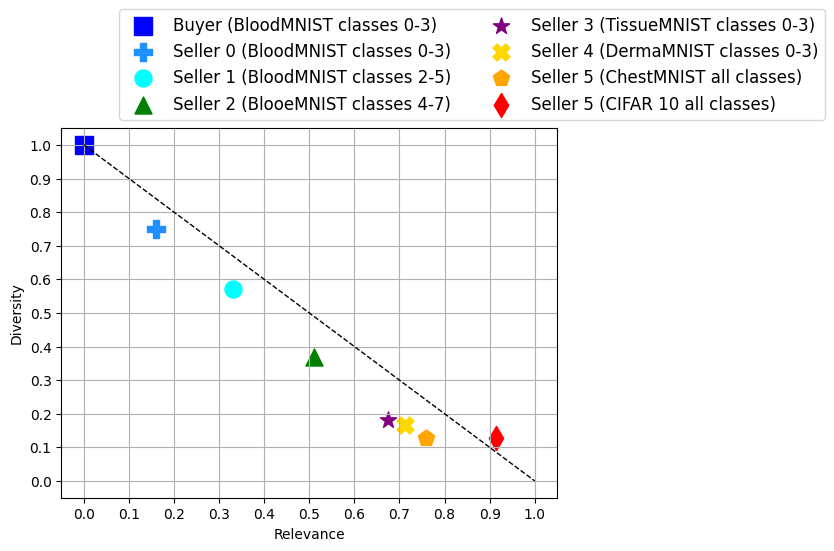

In [198]:
s = 150
plt.figure()
plt.scatter(buyer_rel, buyer_div, marker='s',  s=s, color='blue',  label='Buyer (BloodMNIST classes 0-3)')
plt.scatter(seller_0_rel, seller_0_div, marker='P',  s=s, color='dodgerblue',  label='Seller 0 (BloodMNIST classes 0-3)')
plt.scatter(seller_1_rel, seller_1_div, marker='o',  s=s, color='cyan',  label='Seller 1 (BloodMNIST classes 2-5)')
plt.scatter(seller_2_rel, seller_2_div, marker='^',  s=s, color='green',  label='Seller 2 (BlooeMNIST classes 4-7)')
plt.scatter(seller_3_rel, seller_3_div, marker='*',  s=s, color='purple',  label='Seller 3 (TissueMNIST classes 0-3)')
plt.scatter(seller_4_rel, seller_4_div, marker='X',  s=s, color='gold',  label='Seller 4 (DermaMNIST classes 0-3)')
plt.scatter(seller_5_rel, seller_5_div, marker='p',  s=s, color='orange',  label='Seller 5 (ChestMNIST all classes)')
plt.scatter(seller_6_rel, seller_5_div, marker='d',  s=s, color='red',  label='Seller 5 (CIFAR 10 all classes)')


plt.plot(np.arange(0, 1.1, 0.1), 1 - np.arange(0, 1.1, 0.1), marker='', markersize = 4, markeredgewidth=1.5, color='black', linestyle='--', linewidth=1)
plt.xlabel('Relevance')
plt.ylabel('Diversity')
plt.legend(prop={'size': 12}, bbox_to_anchor=(0.10, 1.00), ncols=2)
plt.grid(True)
plt.yticks([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
plt.xticks([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
plt.savefig('medmnist.png', bbox_inches='tight', )
plt.show()

In [4]:
dataset = 'mnist'
dataset = 'fashion'
dataset = 'cifar'

if dataset == 'mnist':
  buyer_data = mnist_test.data[:, None].repeat(1, 3, 1, 1) / 255
  seller_data = mnist_train.data[:, None].repeat(1, 3, 1, 1) / 255
  buyer_targets = mnist_test.targets
  seller_targets = mnist_train.targets
elif dataset == 'fashion':
  buyer_data = fashion_test.data[:, None].repeat(1, 3, 1, 1) / 255
  seller_data = fashion_train.data[:, None].repeat(1, 3, 1, 1) / 255
  buyer_targets = fashion_test.targets
  seller_targets = fashion_train.targets
elif dataset == 'cifar':
  buyer_data = torch.tensor(np.moveaxis(cifar_test.data, -1, 1))
  seller_data = torch.tensor(np.moveaxis(cifar_train.data, -1, 1))
  buyer_targets = cifar_test.targets
  seller_targets = cifar_train.targets

In [5]:
k = 1000
import numpy as np
normalize = lambda x: (x - x.mean(axis=0))
tensor = lambda x: torch.tensor(x, device='cuda', dtype=torch.float)
upsample = lambda x: torch.nn.Upsample(scale_factor=2)(x)
inference = lambda x: model(x)
# add_dummy_channels = lambda x: (x[:, None].repeat(1, 3, 1, 1) if x.ndim == 3 or x.shape[1] == 1 else x)
# channels_first = lambda x: (np.moveaxis(x, -1, 1) if x.shape[-1] != x.shape[-2] else x)

embed = lambda x: normalize(inference(upsample(tensor(x))))

buyer = buyer_data[np.isin(np.array(buyer_targets), np.arange(4))][:k].float()
seller_0 = seller_data[np.isin(np.array(seller_targets), np.arange(1, 3))][:k].float()
seller_1 = seller_data[np.isin(np.array(seller_targets), np.arange(1, 5))][:k].float()
seller_2 = seller_data[np.isin(np.array(seller_targets), np.arange(2, 6))][:k].float()
seller_3 = seller_data[np.isin(np.array(seller_targets), np.arange(10))][:k].float()
seller_4 = seller_data[np.isin(np.array(seller_targets), np.arange(5, 10))][:k].float()
buyer_embed = embed(buyer).detach().cpu().numpy()
seller_0_embed = embed(seller_0).detach().cpu().numpy()
seller_1_embed = embed(seller_1).detach().cpu().numpy()
seller_2_embed = embed(seller_2).detach().cpu().numpy()
seller_3_embed = embed(seller_3).detach().cpu().numpy()
seller_4_embed = embed(seller_4).detach().cpu().numpy()
print(f'{buyer_embed.shape=}')
print(f'{seller_0_embed.shape=}')
print(f'{seller_1_embed.shape=}')
print(f'{seller_2_embed.shape=}')
print(f'{seller_3_embed.shape=}')
print(f'{seller_4_embed.shape=}')

/tmp/ipykernel_179329/2467550431.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tensor = lambda x: torch.tensor(x, device='cuda', dtype=torch.float)


buyer_embed.shape=(1000, 1000)
seller_0_embed.shape=(1000, 1000)
seller_1_embed.shape=(1000, 1000)
seller_2_embed.shape=(1000, 1000)
seller_3_embed.shape=(1000, 1000)
seller_4_embed.shape=(1000, 1000)


In [6]:
cov = lambda mat: (1 / mat.shape[0]) * mat.T @ mat

def svd(covariance_matrix):
  eig_val, eig_vec = np.linalg.eig(covariance_matrix)
  eig_val = eig_val.real
  return eig_val, eig_vec

# buyer_cov = cov(buyer.reshape(-1, 28*28))
# buyer_eig_val, buyer_eig_vec = svd(buyer_cov)
# seller_0_cov = cov(seller_0.reshape(-1, 28*28))
# seller_1_cov = cov(seller_1.reshape(-1, 28*28))
# seller_2_cov = cov(seller_2.reshape(-1, 28*28))
# seller_3_cov = cov(seller_3.reshape(-1, 28*28))
# seller_4_cov = cov(seller_4.reshape(-1, 28*28))
buyer_cov = cov(buyer_embed)
buyer_eig_val, buyer_eig_vec = svd(buyer_cov)
seller_0_cov = cov(seller_0_embed)
seller_1_cov = cov(seller_1_embed)
seller_2_cov = cov(seller_2_embed)
seller_3_cov = cov(seller_3_embed)
seller_4_cov = cov(seller_4_embed)

In [7]:
def div_rel_func(buyer_eig_val, buyer_eig_vec, seller_covariance, threshold=1e-0):
    
    seller_eig_val = np.zeros([len(seller_covariance)])

    Diversity = 1
    Relevance = 1
    count_root = 0

    for i in range(len(seller_covariance)):
        
        if buyer_eig_val[i] >= threshold:
            
            count_root += 1
            
            vec_seller_covariance = np.matmul(seller_covariance, buyer_eig_vec[:, i])

            seller_eig_val[i] = np.abs(np.linalg.norm(vec_seller_covariance))

            Diversity *= np.abs(seller_eig_val[i] - buyer_eig_val[i]) / max(seller_eig_val[i], buyer_eig_val[i])
            Relevance *= min(seller_eig_val[i], buyer_eig_val[i]) / max(seller_eig_val[i], buyer_eig_val[i]) 
            # Relevance *= (seller_eig_val[i] + buyer_eig_val[i]) / max(seller_eig_val[i], buyer_eig_val[i])


    return (Diversity)**(1/count_root), (Relevance)**(1/count_root), count_root
    
print(div_rel_func(buyer_eig_val, buyer_eig_vec, buyer_cov))
print(div_rel_func(buyer_eig_val, buyer_eig_vec, seller_0_cov))
print(div_rel_func(buyer_eig_val, buyer_eig_vec, seller_1_cov))
print(div_rel_func(buyer_eig_val, buyer_eig_vec, seller_2_cov))
print(div_rel_func(buyer_eig_val, buyer_eig_vec, seller_3_cov))
print(div_rel_func(buyer_eig_val, buyer_eig_vec, seller_4_cov))

(0.0, 0.9999952241449275, 201)
(0.6761767225116152, 0.1343479199949387, 201)
(0.6331396764701799, 0.15044012111066032, 201)
(0.7040199172558692, 0.13755387001544564, 201)
(0.6534693302172698, 0.13895093793087612, 201)
(0.7351129184146773, 0.11160446196831582, 201)


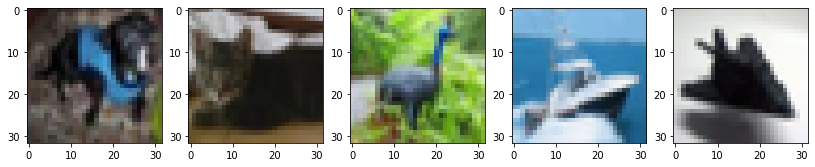

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
dogs = cifar_train.data[np.array(cifar_train.targets) == 5]
cats = cifar_train.data[np.array(cifar_train.targets) == 3]
birds = cifar_train.data[np.array(cifar_train.targets) == 2]
ships = cifar_train.data[np.array(cifar_train.targets) == 8]
planes = cifar_train.data[np.array(cifar_train.targets) == 0]

fig, ax = plt.subplots(ncols=5, figsize=(14, 6))
ax[0].imshow(dogs[0])
ax[1].imshow(cats[0])
ax[2].imshow(birds[0])
ax[3].imshow(ships[0])
ax[4].imshow(planes[0])
plt.show()

In [ ]:
import torch
import torch.nn as nn

In [ ]:
from sklearn.decomposition import PCA

In [ ]:
upsample = lambda x: nn.Upsample(scale_factor=2)(torch.tensor(x, device='cuda', dtype=torch.float).moveaxis(-1, 1))
buyer_data = model(upsample(dogs[:200])).detach().cpu().numpy()
seller0_data = model(upsample(dogs[200:2200])).detach().cpu().numpy()
seller1_data = model(upsample(cats[:2000])).detach().cpu().numpy()
seller2_data = model(upsample(birds[:2000])).detach().cpu().numpy()
seller3_data = model(upsample(ships[:2000])).detach().cpu().numpy()
seller4_data = model(upsample(planes[:2000])).detach().cpu().numpy()

# upsample = lambda x: nn.Upsample(scale_factor=2)(torch.tensor(x - x.mean()).float())
# buyer_data = model(upsample(pneumonia.imgs[pneumonia.labels][:200].repeat(3, 1))).detach().numpy()
# seller1_data = model(upsample(pneumonia.imgs[~pneumonia.labels][:2000].repeat(3, 1))).detach().numpy()
# seller2_data = model(upsample(chest.imgs[:2000][:, None].repeat(3, 1))).detach().numpy()
# seller3_data = model(upsample(tissue.imgs[:2000][:, None].repeat(3, 1))).detach().numpy()
# seller4_data = model(upsample(np.moveaxis(blood.imgs[:2000], -1, 1))).detach().numpy()


In [ ]:
# pca = PCA(n_components=2)
pca = PCA()
pca.fit(buyer_data)

PCA()

In [ ]:
seller1_data.shape,

((2000, 4096),)

In [ ]:
# zero mean each feature in seller data
scaled_seller0 = seller0_data - seller0_data.mean(0)
C0 = scaled_seller0.T @ scaled_seller0 
scaled_seller1 = seller1_data - seller1_data.mean(0)
C1 = scaled_seller1.T @ scaled_seller1 
scaled_seller2 = seller2_data - seller2_data.mean(0)
C2 = scaled_seller2.T @ scaled_seller2 
scaled_seller3 = seller3_data - seller3_data.mean(0)
C3 = scaled_seller3.T @ scaled_seller3 
scaled_seller4 = seller4_data - seller4_data.mean(0)
C4 = scaled_seller4.T @ scaled_seller4 

In [ ]:
num_lambdas = (pca.singular_values_ > 1).sum()
print(num_lambdas)

199


(4096, 4096)

In [ ]:
l2_norm = lambda x: np.sqrt((x**2).sum())

def get_lambdas(buyer_components, seller_data, num_lambdas=2):
  buyer_lambdas = buyer_components[:num_lambdas]
  _seller_data = seller_data[:num_lambdas]
  _seller_data -= _seller_data.mean(0) # zero mean each feature
  seller_covariance = _seller_data.T @ _seller_data
  print(seller_covariance.shape, buyer_lambdas.shape)
  N = _seller_data.shape[0]

  return {i: l2_norm((seller_covariance @ v) / N) for i, v in enumerate(buyer_lambdas)}

def diversity(buyer_lambdas, seller_lambdas, num_lambdas=2):
  result = 1
  for lam_b, lam_s in zip(buyer_lambdas, seller_lambdas.values()):
    num = abs(lam_b - lam_s) 
    dom = max(lam_b, lam_s) 
    result *= (num / dom)**(1 / num_lambdas)
  return result

def relevance(buyer_lambdas, seller_lambdas, num_lambdas=2):
  result = 1
  for lam_b, lam_s in zip(buyer_lambdas, seller_lambdas.values()):
    num = min(lam_b, lam_s) 
    dom = max(lam_b, lam_s) 
    result *= (num / dom)**(1 / num_lambdas)
  return result

num_lambdas=100
buyer_components = pca.components_
seller_lambdas = get_lambdas(buyer_components, seller0_data, num_lambdas)
buyer_lambdas = pca.singular_values_
print('diversity', diversity(buyer_lambdas, seller_lambdas, num_lambdas))
print('relevance', relevance(buyer_lambdas, seller_lambdas, num_lambdas))

(4096, 4096) (100, 4096)
diversity 0.9609348734182672
relevance 0.036828910118730976


In [ ]:
# def diversity(l1_buyer, l2_buyer, l1_seller, l2_seller):
#   num = abs(l1_buyer - l1_seller) * abs(l2_buyer - l2_seller)
#   dom = max(l1_buyer, l1_seller) * max(l2_buyer, l2_seller)
#   return np.sqrt(num / dom)
  
# def relevance(l1_buyer, l2_buyer, l1_seller, l2_seller):
#   num = min(l1_buyer, l1_seller) * min(l2_buyer, l2_seller)
#   dom = max(l1_buyer, l1_seller) * max(l2_buyer, l2_seller)
#   return np.sqrt(num / dom)
  

In [ ]:
D = 4096
noise = np.random.normal(0, size=(2000, D))

noise_lambdas = {i: l2_norm((noise.T @ noise @ pca.components_[i]) / D) for i in range(num_lambdas)}


In [ ]:
num_lambdas = 100

print(diversity(pca.singular_values_[:num_lambdas], noise_lambdas))
print(relevance(pca.singular_values_[:num_lambdas], noise_lambdas))

seller0_lambdas = get_lambdas(pca.components_, seller0_data, num_lambdas)
print(diversity(pca.singular_values_[:num_lambdas], seller0_lambdas))
print(relevance(pca.singular_values_[:num_lambdas], seller0_lambdas))

seller1_lambdas = get_lambdas(pca.components_, seller1_data, num_lambdas)
print(diversity(pca.singular_values_[:num_lambdas], seller1_lambdas))
print(relevance(pca.singular_values_[:num_lambdas], seller1_lambdas))

seller2_lambdas = get_lambdas(pca.components_, seller2_data, num_lambdas)
print(diversity(pca.singular_values_[:num_lambdas], seller2_lambdas))
print(relevance(pca.singular_values_[:num_lambdas], seller2_lambdas))

seller3_lambdas = get_lambdas(pca.components_, seller3_data, num_lambdas)
print(diversity(pca.singular_values_[:num_lambdas], seller3_lambdas))
print(relevance(pca.singular_values_[:num_lambdas], seller3_lambdas))

seller4_lambdas = get_lambdas(pca.components_, seller4_data, num_lambdas)
print(diversity(pca.singular_values_[:num_lambdas], seller4_lambdas))
print(relevance(pca.singular_values_[:num_lambdas], seller4_lambdas))

0.9330962540776832
5.740730127186661e-151
(4096, 4096) (100, 4096)
0.1923249260104081
2.8000234188692155e-77
(4096, 4096) (100, 4096)
0.18779183393647067
9.705139851919842e-77
(4096, 4096) (100, 4096)
0.24597136148574775
2.2036080804626153e-81
(4096, 4096) (100, 4096)
0.12143430956860089
1.0148630700324253e-71


In [4]:
!pip install tensorflow keras seaborn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 293.3/293.3 kB 13.6 MB/s eta 0:00:00

[notice] A new release of pip available: 22.2.2 -> 23.1.2
[notice] To update, run: pip install --upgrade pip


In [17]:
Data_buyer.shape

(6117, 784)

In [11]:
Data_buyer.mean(0).shape

(784,)

In [42]:
np.abs(cov_data_seller0).sum()

2472.217

In [38]:

np.linalg.norm(np.matmul(cov_data_seller0, U_base[:, 0]))

4.068107

In [34]:
# cov_data_seller0.sum(0)

In [36]:
# L_base

In [48]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Mon May 23 15:26:59 2022

@author: mohammad
"""

### We conpensate the error at all the devices and the PS
# import keras
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.utils import np_utils
# from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras.datasets import cifar10
from keras import regularizers
from keras.callbacks import LearningRateScheduler
import numpy as np
from tensorflow.keras import datasets
#from keras.datasets import cifar10
from keras.datasets.mnist import load_data
from keras.datasets import fashion_mnist
import random
from numpy import loadtxt
import math
from tensorflow.keras.utils import to_categorical
from tensorflow.python.framework.graph_util import convert_variables_to_constants
from tensorflow.python.platform import gfile
from tensorflow.python.framework import tensor_util
from tensorflow.keras.models import load_model
from keras.models import model_from_json
from keras import backend as Kback
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
import matplotlib
# matplotlib.use('pdf')


noise_var = 1
threshold = 1e-2
num_samples = 1000
use_gram = True
# use_gram = False

def normalize(arr):
    arr = arr - arr.mean(axis=0)
    return arr


def div_rel_func(baseline, data):
    
    L_data = np.zeros([len(data)])

    Diversity = 1
    Relevance = 1
    count_root = 0

    for i in range(len(data)):
        
        if L_base[i] >= threshold:
            
            count_root += 1
            
            vec_data = np.matmul(data, U_base[:, i])

            L_data[i] = np.abs(np.linalg.norm(vec_data))

            Diversity *= np.abs(L_data[i] - L_base[i]) / max(L_data[i], L_base[i])
            Relevance *= min(L_data[i], L_base[i]) / max(L_data[i], L_base[i]) 
            # print(min(L_data[i], L_base[i]))

    print(count_root)
    return (Diversity)**(1/count_root), (Relevance)**(1/count_root)


def covariance(data, use_gram=use_gram):
    n = len(data)
    if use_gram:
        cov = np.matmul(np.transpose(data), data) # Gram matrix
    else:
        cov = np.matmul(data, np.transpose(data)) # Covariance matrix
    return (1/n) * cov

##%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% load dataset mnist %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%##
(x_train, y_train), (x_test, y_test) = load_data()
image_height = x_train.shape[1]
image_width = x_train.shape[2]

train_data = np.reshape(x_train, (x_train.shape[0], image_height * image_width))
test_data = np.reshape(x_test, (x_test.shape[0], image_height * image_width))
train_data = train_data.astype('float32')/255.0
test_data = test_data.astype('float32')/255.0

 
num_classes = 10
train_label = np_utils.to_categorical(y_train,num_classes)
test_label = np_utils.to_categorical(y_test,num_classes)


ind_dataset_0 = [ind for ind in range(60000) if train_label[ind, 0] == 1.0][:num_samples]
ind_dataset_1 = [ind for ind in range(60000) if train_label[ind, 1] == 1.0][:num_samples]
ind_dataset_2 = [ind for ind in range(60000) if train_label[ind, 2] == 1.0][:num_samples]
ind_dataset_3 = [ind for ind in range(60000) if train_label[ind, 3] == 1.0][:num_samples]
ind_dataset_4 = [ind for ind in range(60000) if train_label[ind, 4] == 1.0][:num_samples]
ind_dataset_5 = [ind for ind in range(60000) if train_label[ind, 5] == 1.0][:num_samples]
ind_dataset_6 = [ind for ind in range(60000) if train_label[ind, 6] == 1.0][:num_samples]
ind_dataset_7 = [ind for ind in range(60000) if train_label[ind, 7] == 1.0][:num_samples]
ind_dataset_8 = [ind for ind in range(60000) if train_label[ind, 8] == 1.0][:num_samples]
ind_dataset_9 = [ind for ind in range(60000) if train_label[ind, 9] == 1.0][:num_samples]
len_ind_0 = len(ind_dataset_0)
len_ind_1 = len(ind_dataset_1)
len_ind_2 = len(ind_dataset_2)
len_ind_3 = len(ind_dataset_3)
len_ind_4 = len(ind_dataset_4)
len_ind_5 = len(ind_dataset_5)
len_ind_6 = len(ind_dataset_6)
len_ind_7 = len(ind_dataset_7)
len_ind_8 = len(ind_dataset_8)
len_ind_9 = len(ind_dataset_9)
#$@$@$@$@$@$@$@$@$@$@#$@$@$@$@$@$@$@$@$@$@#$@$@$@$@$@$#

##%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% load dataset fashion mnist %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%##
(x_train_f, y_train_f), (x_test_f, y_test_f) = fashion_mnist.load_data()
image_height_f = x_train_f.shape[1]
image_width_f = x_train_f.shape[2]

train_data_f = np.reshape(x_train_f, (x_train_f.shape[0], image_height_f * image_width_f))
test_data_f = np.reshape(x_test_f, (x_test_f.shape[0], image_height_f * image_width_f))
train_data_f = train_data_f.astype('float32')/255.0
test_data_f = test_data_f.astype('float32')/255.0

 
num_classes_f = 10
train_label_f = np_utils.to_categorical(y_train_f,num_classes_f)
test_label_f = np_utils.to_categorical(y_test_f,num_classes_f)


ind_dataset_0_f = [ind for ind in range(60000) if train_label_f[ind, 0] == 1.0][:num_samples]
ind_dataset_1_f = [ind for ind in range(60000) if train_label_f[ind, 1] == 1.0][:num_samples]
ind_dataset_2_f = [ind for ind in range(60000) if train_label_f[ind, 2] == 1.0][:num_samples]
ind_dataset_3_f = [ind for ind in range(60000) if train_label_f[ind, 3] == 1.0][:num_samples]
ind_dataset_4_f = [ind for ind in range(60000) if train_label_f[ind, 4] == 1.0][:num_samples]
ind_dataset_5_f = [ind for ind in range(60000) if train_label_f[ind, 5] == 1.0][:num_samples]
ind_dataset_6_f = [ind for ind in range(60000) if train_label_f[ind, 6] == 1.0][:num_samples]
ind_dataset_7_f = [ind for ind in range(60000) if train_label_f[ind, 7] == 1.0][:num_samples]
ind_dataset_8_f = [ind for ind in range(60000) if train_label_f[ind, 8] == 1.0][:num_samples]
ind_dataset_9_f = [ind for ind in range(60000) if train_label_f[ind, 9] == 1.0] [:num_samples]
len_ind_0_f = len(ind_dataset_0_f)
len_ind_1_f = len(ind_dataset_1_f)
len_ind_2_f = len(ind_dataset_2_f)
len_ind_3_f = len(ind_dataset_3_f)
len_ind_4_f = len(ind_dataset_4_f)
len_ind_5_f = len(ind_dataset_5_f)
len_ind_6_f = len(ind_dataset_6_f)
len_ind_7_f = len(ind_dataset_7_f)
len_ind_8_f = len(ind_dataset_8_f)
len_ind_9_f = len(ind_dataset_9_f)
#$@$@$@$@$@$@$@$@$@$@#$@$@$@$@$@$@$@$@$@$@#$@$@$@$@$@$#


#%#%#%#%#%#%#%#%#% Buyer dataset #%#%#%#%#%#%#%#%#% 
Data_buyer_ind = np.concatenate((ind_dataset_0[0:1*int(len_ind_0/5)],
                             ind_dataset_1[0:1*int(len_ind_1/5)],
                             ind_dataset_2[0:1*int(len_ind_2/5)],
                             ind_dataset_3[0:1*int(len_ind_3/5)],
                             ind_dataset_4[0:1*int(len_ind_4/5)]))

Data_buyer = train_data[Data_buyer_ind, :]

### normalize data
Data_buyer = normalize(Data_buyer)

cov_data_buyer = covariance(Data_buyer)

L_base, U_base = np.linalg.eig(cov_data_buyer)
L_base = np.abs(L_base)

######### plotting the largest eigenvector
# max_loc = np.argsort(np.abs(L_buyer))[-1] #np.argmax(np.abs(L_buyer))
# max_eigenvec = U_buyer[:, max_loc]

# print(max_eigenvec, L_buyer[max_loc])
# ax = sns.heatmap(np.reshape(max_eigenvec, (image_height, image_width)), linewidth=0.5)
# plt.show()


######### plotting eigenvalues
# L_buyer_sort = np.sort(L_buyer)[::-1]
# plt.plot(L_buyer_sort[L_buyer_sort>=threshold])
# plt.show() 

#%#%#%#%#%#%#%#%#% Seller 0 dataset #%#%#%#%#%#%#%#%#% 
Data_seller0_ind = np.concatenate((ind_dataset_1[1*int(len_ind_1/5):2*int(len_ind_1/5)],
                             ind_dataset_2[1*int(len_ind_2/5):2*int(len_ind_2/5)],
                             ind_dataset_3[1*int(len_ind_3/5):2*int(len_ind_3/5)],
                             ind_dataset_4[1*int(len_ind_4/5):2*int(len_ind_4/5)],
                             ind_dataset_5[0*int(len_ind_5/5):1*int(len_ind_5/5)]))

Data_seller0 = train_data[Data_seller0_ind, :]

### normalize data
Data_seller0 = normalize(Data_seller0)

cov_data_seller0 = covariance(Data_seller0)

Diversity_0, Relevance_0 = div_rel_func(cov_data_buyer, cov_data_seller0)


print('Diversity seller 0:', Diversity_0)
print('Relevance seller 0:', Relevance_0)

#%#%#%#%#%#%#%#%#% Seller 1 dataset #%#%#%#%#%#%#%#%#% 
Data_seller1_ind = np.concatenate((ind_dataset_5[1*int(len_ind_5/5):2*int(len_ind_5/5)],
                             ind_dataset_6[0:1*int(len_ind_6/5)],
                             ind_dataset_7[0:1*int(len_ind_7/5)],
                             ind_dataset_8[0:1*int(len_ind_8/5)],
                             ind_dataset_9[0:1*int(len_ind_9/5)]))

Data_seller1 = train_data[Data_seller1_ind, :]

### normalize data
Data_seller1 = normalize(Data_seller1)

cov_data_seller1 = covariance(Data_seller1)

Diversity_1, Relevance_1 = div_rel_func(cov_data_buyer, cov_data_seller1)

print('Diversity seller 1:', Diversity_1)
print('Relevance seller 1:', Relevance_1)


#%#%#%#%#%#%#%#%#% Seller 2 dataset #%#%#%#%#%#%#%#%#% 
Data_seller2_ind = np.concatenate((ind_dataset_0[int(1*len_ind_0/5):int(1.5*len_ind_0/5)],
                                   ind_dataset_1[int(2*len_ind_1/5):int(2.5*len_ind_1/5)],
                                   ind_dataset_2[int(2*len_ind_2/5):int(2.5*len_ind_2/5)],
                                   ind_dataset_3[int(2*len_ind_3/5):int(2.5*len_ind_3/5)],
                                   ind_dataset_4[int(2*len_ind_4/5):int(2.5*len_ind_4/5)],
                                   ind_dataset_5[int(2*len_ind_5/5):int(2.5*len_ind_5/5)],
                                   ind_dataset_6[int(len_ind_6/5):int(1.5*len_ind_6/5)],
                                   ind_dataset_7[int(len_ind_7/5):int(1.5*len_ind_7/5)],
                                   ind_dataset_8[int(len_ind_8/5):int(1.5*len_ind_8/5)],
                                   ind_dataset_9[int(len_ind_9/5):int(1.5*len_ind_9/5)]))

Data_seller2 = train_data[Data_seller2_ind, :]

### normalize data
Data_seller2 = normalize(Data_seller2)

cov_data_seller2 = covariance(Data_seller2)

Diversity_2, Relevance_2 = div_rel_func(cov_data_buyer, cov_data_seller2)

print('Diversity seller 2:', Diversity_2)
print('Relevance seller 2:', Relevance_2)


#%#%#%#%#%#%#%#%#% Seller 3 dataset #%#%#%#%#%#%#%#%#% 
Data_seller3_ind = np.concatenate((ind_dataset_0[int(1.5*len_ind_0/5):int(2.5*len_ind_0/5)],
                                   ind_dataset_1[int(2.5*len_ind_1/5):int(3.5*len_ind_1/5)],
                                   ind_dataset_2[int(2.5*len_ind_2/5):int(3.5*len_ind_2/5)],
                                   ind_dataset_3[int(2.5*len_ind_3/5):int(3.5*len_ind_3/5)],
                                   ind_dataset_4[int(2.5*len_ind_4/5):int(3.5*len_ind_4/5)]))

Data_seller3 = train_data[Data_seller3_ind, :]

### normalize data
Data_seller3 = normalize(Data_seller3)

cov_data_seller3 = covariance(Data_seller3)

Diversity_3, Relevance_3 = div_rel_func(cov_data_buyer, cov_data_seller3)

print('Diversity seller 3:', Diversity_3)
print('Relevance seller 3:', Relevance_3)


#%#%#%#%#%#%#%#%#% Seller 4 dataset #%#%#%#%#%#%#%#%#% 
# Data_seller4_ind = np.concatenate((ind_dataset_0[int(2.5*len_ind_0/5):int(3.5*len_ind_0/5)],
#                                     ind_dataset_1[int(3.5*len_ind_1/5):int(4.5*len_ind_1/5)],
#                                     ind_dataset_2[int(3.5*len_ind_2/5):int(4.5*int(len_ind_2/5))],
#                                     ind_dataset_7[int(1.5*len_ind_7/5):int(2.5*int(len_ind_7/5))],
#                                     ind_dataset_8[int(1.5*len_ind_8/5):int(2.5*len_ind_8/5)],
#                                     ind_dataset_9[int(1.5*len_ind_9/5):int(2.5*len_ind_9/5)]))
Data_seller4_ind = np.concatenate((ind_dataset_3[int(2.5*len_ind_3/5):int(3.5*len_ind_3/5)],
                                    ind_dataset_4[int(3.5*len_ind_4/5):int(4.5*len_ind_4/5)],
                                    ind_dataset_5[int(3.5*len_ind_5/5):int(4.5*int(len_ind_5/5))],
                                    ind_dataset_6[int(3.5*len_ind_6/5):int(4.5*int(len_ind_6/5))],
                                    ind_dataset_7[int(1.5*len_ind_7/5):int(2.5*int(len_ind_7/5))],
                                    ind_dataset_8[int(1.5*len_ind_8/5):int(2.5*len_ind_8/5)],
                                    ind_dataset_9[int(1.5*len_ind_9/5):int(2.5*len_ind_9/5)]))

Data_seller4 = train_data[Data_seller4_ind, :]

### normalize data
Data_seller4 = normalize(Data_seller4)

cov_data_seller4 = covariance(Data_seller4)

Diversity_4, Relevance_4 = div_rel_func(cov_data_buyer, cov_data_seller4)

print('Diversity seller 4:', Diversity_4)
print('Relevance seller 4:', Relevance_4)


#%#%#%#%#%#%#%#%#% Seller 5 dataset #%#%#%#%#%#%#%#%#% 
Data_seller5_ind = np.concatenate((ind_dataset_0[int(3.5*len_ind_0/5):int(4.5*len_ind_0/5)],
                                   ind_dataset_9[int(2.5*len_ind_9/5):int(3.5*len_ind_9/5)]))

Data_seller5 = train_data[Data_seller5_ind, :]

### normalize data
Data_seller5 = normalize(Data_seller5)

cov_data_seller5 = covariance(Data_seller5)

Diversity_5, Relevance_5 = div_rel_func(cov_data_buyer, cov_data_seller5)

print('Diversity seller 5:', Diversity_5)
print('Relevance seller 5:', Relevance_5)

#%#%#%#%#%#%#%#%#% Seller 6 dataset #%#%#%#%#%#%#%#%#% 
Data_seller6_ind = np.concatenate((2*ind_dataset_0[int(len_ind_0/5):3*int(len_ind_0/5)],
                                    2*ind_dataset_1[int(len_ind_1/5):3*int(len_ind_1/5)],
                                    2*ind_dataset_2[int(len_ind_2/5):3*int(len_ind_2/5)],
                                    2*ind_dataset_3[int(len_ind_3/5):3*int(len_ind_3/5)],
                                    2*ind_dataset_4[int(len_ind_4/5):3*int(len_ind_4/5)],
                                    2*ind_dataset_5[int(len_ind_5/5):3*int(len_ind_5/5)],
                                    2*ind_dataset_6[int(len_ind_6/5):3*int(len_ind_6/5)],
                                    2*ind_dataset_7[int(len_ind_7/5):3*int(len_ind_7/5)],
                                    2*ind_dataset_8[int(len_ind_8/5):3*int(len_ind_8/5)],
                                    2*ind_dataset_9[int(len_ind_9/5):3*int(len_ind_9/5)]))

Data_seller6 = train_data[Data_seller6_ind, :] 
Data_seller6_n, Data_seller6_d =  Data_seller6.shape[0], Data_seller6.shape[1]
# Data_seller6 += np.random.normal(0, noise_var, (Data_seller6_n, Data_seller6_d))
Data_seller6 = np.random.normal(0, noise_var, (Data_seller6_n, Data_seller6_d))

### normalize data
Data_seller6 = normalize(Data_seller6)

cov_data_seller6 = covariance(Data_seller6)

Diversity_6, Relevance_6 = div_rel_func(cov_data_buyer, cov_data_seller6)

print('Diversity seller 6:', Diversity_6)
print('Relevance seller 6:', Relevance_6)

 



#%#%#%#%#%#%#%#%#% Seller 7 dataset #%#%#%#%#%#%#%#%#% 
Data_seller7_ind = ind_dataset_5_f[0:1*int(len_ind_5_f)]

Data_seller7 = train_data_f[Data_seller7_ind, :]

### normalize data
Data_seller7 = normalize(Data_seller7)

cov_data_seller7 = covariance(Data_seller7)

Diversity_7, Relevance_7 = div_rel_func(cov_data_buyer, cov_data_seller7)

print('Diversity seller 7:', Diversity_7)
print('Relevance seller 7:', Relevance_7)

 



#%#%#%#%#%#%#%#%#% Seller 8 dataset #%#%#%#%#%#%#%#%#% 
Data_seller8_ind = ind_dataset_0_f[0:1*int(len_ind_0_f)]

Data_seller8 = train_data_f[Data_seller8_ind, :]

### normalize data
Data_seller8 = normalize(Data_seller8)

cov_data_seller8 = covariance(Data_seller8)

Diversity_8, Relevance_8 = div_rel_func(cov_data_buyer, cov_data_seller8)

print('Diversity seller 8:', Diversity_8)
print('Relevance seller 8:', Relevance_8)

 



#%#%#%#%#%#%#%#%#% Seller 9 dataset #%#%#%#%#%#%#%#%#% 
Data_seller9_ind = ind_dataset_4_f[0:1*int(len_ind_4_f)]

Data_seller9 = train_data_f[Data_seller9_ind, :]

### normalize data
Data_seller9 = normalize(Data_seller9)

cov_data_seller9 = covariance(Data_seller9)

Diversity_9, Relevance_9 = div_rel_func(cov_data_buyer, cov_data_seller9)

print('Diversity seller 9:', Diversity_9)
print('Relevance seller 9:', Relevance_9)

 



#%#%#%#%#%#%#%#%#% Seller 10 dataset #%#%#%#%#%#%#%#%#% 
Data_seller10_ind = ind_dataset_7_f[0:1*int(len_ind_7_f)]

Data_seller10 = train_data_f[Data_seller10_ind, :]

### normalize data
Data_seller10 = normalize(Data_seller10)

cov_data_seller10 = covariance(Data_seller10)

Diversity_10, Relevance_10 = div_rel_func(cov_data_buyer, cov_data_seller10)

print('Diversity seller 10:', Diversity_10)
print('Relevance seller 10:', Relevance_10)

221
Diversity seller 0: 0.46838519099849135
Relevance seller 0: 0.4205972019781383
221
Diversity seller 1: 0.6705121587588223
Relevance seller 1: 0.2601038198637191
221
Diversity seller 2: 0.5640872803970346
Relevance seller 2: 0.35661377063964117
221
Diversity seller 3: 0.3794437449763114
Relevance seller 3: 0.4778639502494412
221
Diversity seller 4: 0.6265517072924388
Relevance seller 4: 0.307538138060599
221
Diversity seller 5: 0.6355646015561434
Relevance seller 5: 0.26776655971276897
221
Diversity seller 6: 0.8338496432383702
Relevance seller 6: 0.04979393017534733
221
Diversity seller 7: 0.6657585882647702
Relevance seller 7: 0.17059710885185492
221
Diversity seller 8: 0.7392304429011397
Relevance seller 8: 0.11976511390773066
221
Diversity seller 9: 0.7378561309503204
Relevance seller 9: 0.11559210574368184
221
Diversity seller 10: 0.6488075574191229
Relevance seller 10: 0.2085326181503605


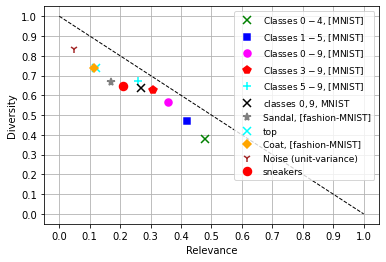

<Figure size 432x288 with 0 Axes>

In [49]:
###################################################################
plt.figure()
plt.plot([Relevance_3], [Diversity_3],
         marker='x', markersize = 7.4, markeredgewidth=1.5, 
         color='green', linestyle='', linewidth=1, label='Classes $0 - 4$, [MNIST]')
plt.plot([Relevance_0], [Diversity_0],
         marker='s', markersize = 6, markeredgewidth=1.5, 
         color='blue', linestyle='', linewidth=1, label='Classes $1 - 5$, [MNIST]')
plt.plot([Relevance_2], [Diversity_2],
         marker='o', markersize = 7, markeredgewidth=1.5, 
         color='magenta', linestyle='', linewidth=1, label='Classes $0 - 9$, [MNIST]')
plt.plot([Relevance_4], [Diversity_4],
          marker='p', markersize = 8, markeredgewidth=1.5, 
          color='red', linestyle='', linewidth=1, label='Classes $3 - 9$, [MNIST]')
plt.plot([Relevance_1], [Diversity_1],
         marker='+', markersize = 8, markeredgewidth=1.5, 
         color='cyan', linestyle='', linewidth=1, label='Classes $5 - 9$, [MNIST]')
plt.plot([Relevance_5], [Diversity_5],
          marker='x', markersize = 8, markeredgewidth=1.5, 
          color='black', linestyle='', linewidth=1, label='classes $0, 9$, MNIST')
plt.plot([Relevance_7], [Diversity_7],
          marker='*', markersize = 8, markeredgewidth=1.5, 
          color='gray', linestyle='', linewidth=1, label='Sandal, [fashion-MNIST]')
plt.plot([Relevance_8], [Diversity_8],
          marker='x', markersize = 8, markeredgewidth=1.5, 
          color='cyan', linestyle='', linewidth=1, label='top')
plt.plot([Relevance_9], [Diversity_9],
          marker='D', markersize = 6, markeredgewidth=1.5, 
          color='orange', linestyle='', linewidth=1, label='Coat, [fashion-MNIST]')
plt.plot([Relevance_6], [Diversity_6],
          marker='1', markersize = 8, markeredgewidth=1.5, 
          color='brown', linestyle='', linewidth=1, label='Noise (unit-variance)')
plt.plot([Relevance_10], [Diversity_10],
          marker='o', markersize = 8, markeredgewidth=1.5, 
          color='red', linestyle='', linewidth=1, label='sneakers')
Range = np.arange(0, 1+0.01, 0.01)
Range_prime = 1 - Range

plt.plot(Range, Range_prime,
         marker='', markersize = 4, markeredgewidth=1.5, 
         color='black', linestyle='--', linewidth=1)
plt.xlabel('Relevance')
plt.ylabel('Diversity')
plt.legend(prop={'size': 9})
plt.grid(True)
# plt.title('MNIST, $[0 - 4]$')
plt.yticks([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
plt.xticks([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
plt.show()

plt.savefig(f'mnist_fashionmnist_{num_samples}_{"gram" if use_gram else "cov"}_{num_samples}.pdf')

        
###################################################################


    
# ## Display logs per epoch step
# if (epoch+1) % display_step == 0:
#     print ("Current epoch:", '%04d' % (epoch+1),
#            ", total epoch:", '%04d' % (epoch+beg_epoch+1),
#            ", test_accuracy:", test_accuracy[epoch],
#            ", loss:", total_cost[epoch])
 
#  ############## Save the model ##############
# if (epoch+1) % Save_ind == 0: 
#     #### Save the model #### 
#     model_json = model.to_json()
#     with open('model.json', 'w') as json_file:
#         json_file.write(model_json)
#         model.save_weights('model.h5')
#  ############################
      # np.savetxt('parameters.dat', parameters, delimiter=',')
#      np.savetxt('acc_nonIID_MNIST_LB_q2_2_tau3_1.dat', test_accuracy, delimiter=',')
#      np.savetxt('los_nonIID_MNIST_LB_q2_2_tau3_1.dat', total_cost, delimiter=',')
#      print("Model saved!")
# ############################
    
    
    